# Execution Time
---
Timothy Helton

2017-05-27

---
I have been fortunate enough to attend two different training courses put on by [Enthought Scientific Computing Solutions](https://www.enthought.com/).
The [instructors](https://www.enthought.com/services/training/instructors/) were Michael McKerns and Alexandre Chabot-Leclerc who really had it together.
The most recent class was [Pandas Mastery Workshop](https://www.enthought.com/services/training/pandas-mastery-workshop/), which I would highly recomend.
During the course Alexandre made comments about performance numerous times, so I made this notebook to display some surprising methods to speed up [Pandas](http://pandas.pydata.org/).

---
### Imports

In [1]:
from collections import namedtuple, OrderedDict
import io
import sys
import timeit

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

---
### Versions

In [2]:
print(f'Numpy Version: {np.__version__}')
print(f'Pandas Version: {pd.__version__}')
print(f'Python Version: {sys.version}')

Numpy Version: 1.12.1
Pandas Version: 0.20.1
Python Version: 3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


---
### Framework

In [3]:
colors = sns.color_palette()

In [45]:
labels = [
    'Pure Numpy',
    'Pure Pandas',
    'Pandas Wrapped by Numpy',
    'Pandas Numpy Calc'
]

In [5]:
Call = namedtuple('Call', ('cmds', 'setup'))

In [6]:
def time_algorithm(cmds, setup=None):
    """Determine execution time.
    
    :param str cmds: commands to be timed
    :param str setup: setup commands
    """
    t = timeit.Timer(cmds, setup=setup)
    n, time = t.autorange()
    return time / n

In [7]:
def format_times(time_data):
    """Combine original times and normalized times.
    
    :param dict time_data: algorithm cycle times
    """
    measured = pd.Series(algorithms,
                         name='measured_times')
    normalized = pd.Series(measured / measured.min(),
                           name='normalized_times')
    return pd.DataFrame([measured, normalized])

In [8]:
def plot_results(results, title, save=False):
    """Plot execution times.
    
    :param DataFrame results: data to be plotted
    :param str title: title of plot
    :param bool save: if True the plot will be saved to disk
    """
    results = results.T
    
    milli_formatter = FuncFormatter(
        lambda x, position: f'{x * 1e3:.3f} ms'
    )

    label_size = 14
    sup_title_size = 24
    title_size = 18
    
    fig = plt.figure('Overview Bor Plot', figsize=(10, 10),
                     facecolor='white', edgecolor='black')
    rows, cols = (2, 2)
    ax0 = plt.subplot2grid((rows, cols), (0, 0))
    ax1 = plt.subplot2grid((rows, cols), (0, 1))
    ax2 = plt.subplot2grid((rows, cols), (1, 0), colspan=2)
        
    # bar plot
    (results.measured_times
         .plot(kind='bar', alpha=0.5, edgecolor='black', ax=ax0))

    ax0.set_title('Measured Times', fontsize=title_size)
    ax0.set_ylabel('Time (s)', fontsize=label_size)
    ax0.yaxis.set_major_formatter(milli_formatter)
    
    # normalizd bar plot
    (results.normalized_times
         .plot(kind='bar', alpha=0.5, color=colors[1],
               edgecolor='black', ax=ax1))

    for p in ax1.patches:
        ax1.annotate(
            f'{p.get_height():.2f}',
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center',
            textcoords='offset points',
            va='center',
            xytext=(0, 5), 
        )
    
    ax1.set_title('Normalized Times', fontsize=title_size)

    for ax in (ax0, ax1):
        ax.set_xlabel('Algorithms', fontsize=label_size)
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(),
                           rotation=75)
    
    # pie plot
    (results.normalized_times
        .plot(kind='pie',
              explode=[0.05] * results.shape[0],
              legend=None, shadow=True, ax=ax2))
    
    ax2.set_aspect('equal')
    ax2.set_ylabel('')
    
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=sup_title_size, y=1.05)

    if save:
        plt.savefig(f'{title}.png', bbox_inches='tight',
                    bbox_extra_artists=[sup_title_size])
    else:
        plt.show()

---
### Overhead

- The following Sunburst images for initializing different data structures were created using [Snakeviz](https://jiffyclub.github.io/snakeviz/).

<table>
    <tr>
        <td scope="row">
            <h5 style="text-align: left">Numpy Array</h5>
            <img src="execution_time_img/numpy_array_profile.png" style="height: 200px"/>
        </td>
        <td scope="row">
            <h5 style="text-align: left">Pandas Series</h5>
            <img src="execution_time_img/pandas_series_profile.png" style="height: 200px"/>
        </td>
        <td scope="row">
            <h5 style="text-align: left">Pandas DataFrame</h5>
            <img src="execution_time_img/pandas_df_profile.png" style="width: 200px"/>
        </td>
    </tr>
</table>


---
### Pandas Series Numerical Operations

- Numerical methods for Pandas are located down the stack resulting in a time delay.
- Converting to a Numpy array, performing the calculation and then back to a DataFrame increases speed.

In [29]:
setup_numpy = ('import numpy as np;'
               'arr = np.arange(1e6);')
setup_pandas = (setup_numpy
                + ('import pandas as pd;'
                   's = pd.Series(arr);'))

#### Addition

In [10]:
calls = (
    Call('arr.sum()', setup_numpy),
    Call('s.sum()', setup_pandas),
    Call('np.sum(s)', setup_pandas),
    Call('pd.Series(s.values.sum())', setup_pandas),
)

algorithms = OrderedDict(
    {x: time_algorithm(y.cmds, y.setup)
     for x, y in zip(labels, calls)}
)
addition = format_times(algorithms)

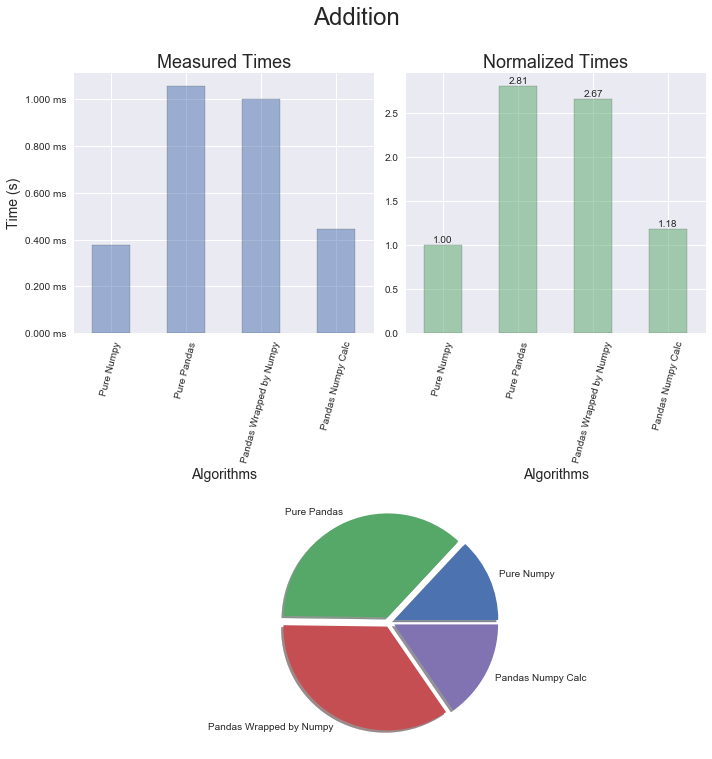

In [11]:
plot_results(addition, 'Addition')

#### Multiplication

In [12]:
calls = (
    Call('arr.prod()', setup_numpy),
    Call('s.prod()', setup_pandas),
    Call('np.prod(s)', setup_pandas),
    Call('pd.Series(s.values.prod())', setup_pandas),
)
algorithms = OrderedDict(
    {x: time_algorithm(y.cmds, y.setup)
     for x, y in zip(labels, calls)}
)
multiplication = format_times(algorithms)

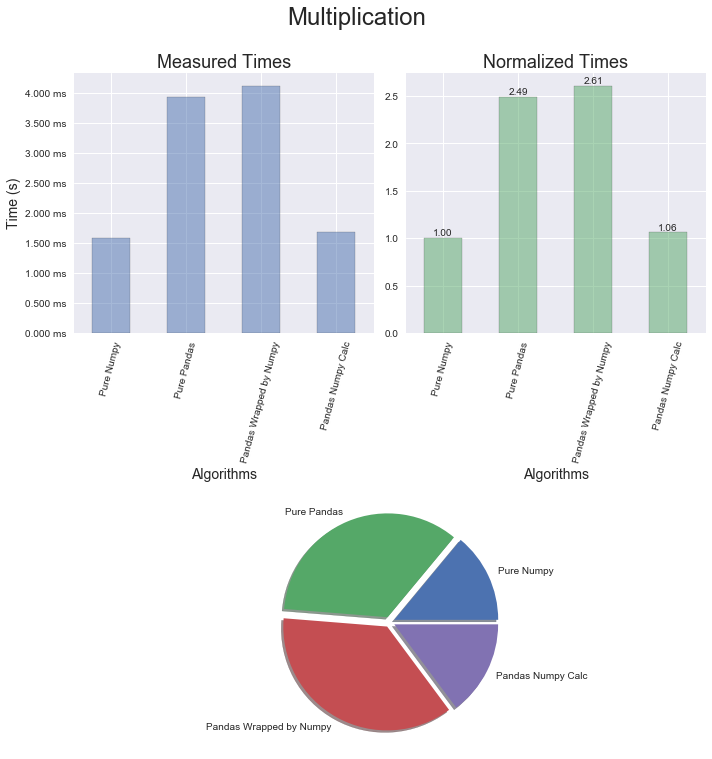

In [13]:
plot_results(multiplication, 'Multiplication')

---

### Pandas DataFrames Numerical Operations

In [30]:
setup_numpy = ('import numpy as np;'
               'arr = np.arange(1e6).reshape(1000, 1000);')
setup_pandas = (setup_numpy
                + ('import pandas as pd;'
                   'df = pd.DataFrame(arr);'))

#### Addition Down Columns

In [15]:
calls = (
    Call('arr.sum()', setup_numpy),
    Call('df.sum()', setup_pandas),
    Call('np.sum(df)', setup_pandas),
    Call('pd.Series(df.values.sum())', setup_pandas),
)
algorithms = OrderedDict(
    {x: time_algorithm(y.cmds, y.setup)
     for x, y in zip(labels, calls)}
)
apply_addition = format_times(algorithms)

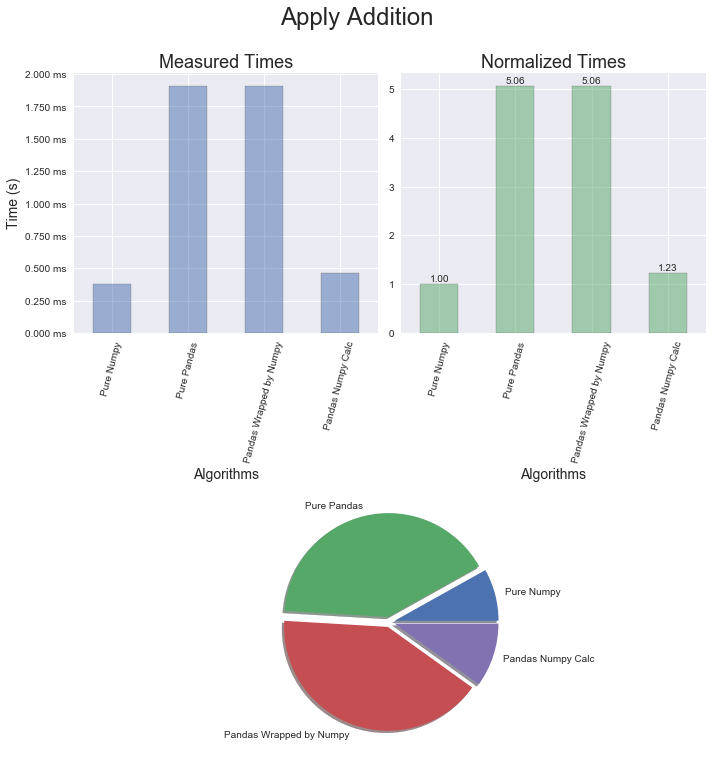

In [16]:
plot_results(apply_addition, 'Apply Addition')

#### Multiplication Down Columns

In [17]:
calls = (
    Call('arr.prod()', setup_numpy),
    Call('df.prod()', setup_pandas),
    Call('np.prod(df)', setup_pandas),
    Call('pd.Series(df.values.prod())', setup_pandas),
)
algorithms = OrderedDict(
    {x: time_algorithm(y.cmds, y.setup)
     for x, y in zip(labels, calls)}
)
apply_prod = format_times(algorithms)

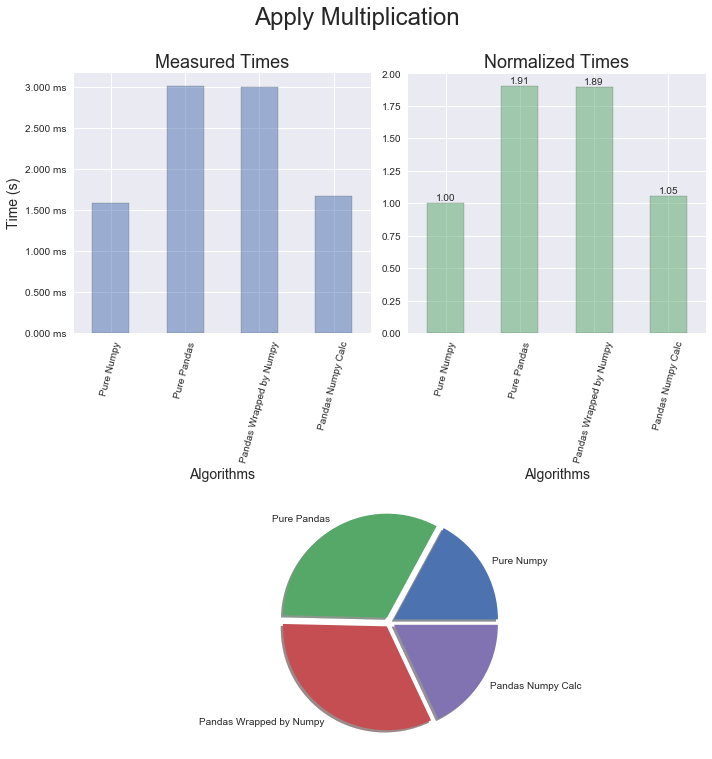

In [18]:
plot_results(apply_prod, 'Apply Multiplication')

#### Addition Across Columns

In [19]:
calls = (
    Call('arr.sum(axis=1)', setup_numpy),
    Call('df.sum(axis=1)', setup_pandas),
    Call('np.sum(df, axis=1)', setup_pandas),
    Call('pd.Series(df.values.sum(axis=1))', setup_pandas),
)
algorithms = OrderedDict(
    {x: time_algorithm(y.cmds, y.setup)
     for x, y in zip(labels, calls)}
)
apply_across_add = format_times(algorithms)

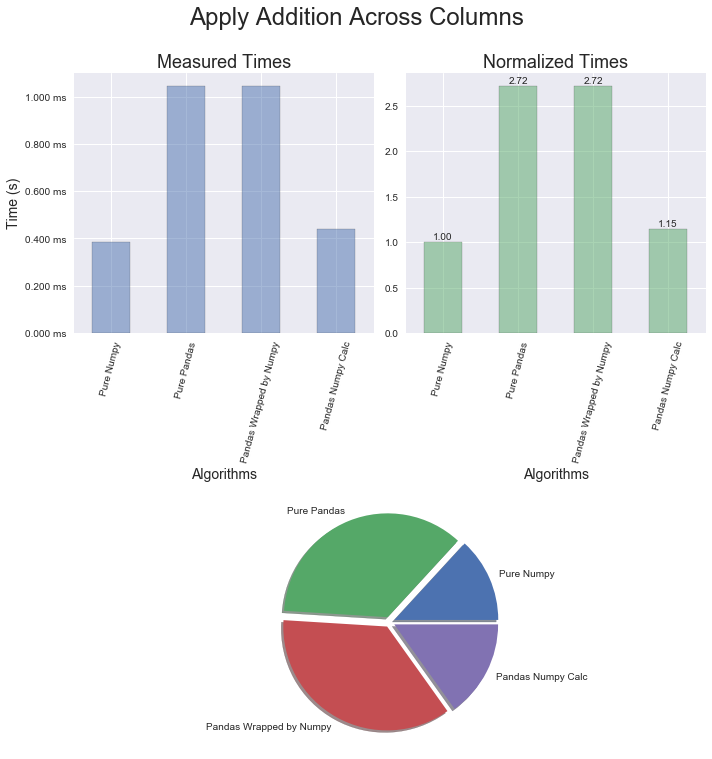

In [20]:
plot_results(apply_across_add, 'Apply Addition Across Columns')

#### Multiplication Across Columns

In [21]:
calls = (
    Call('arr.prod(axis=1)', setup_numpy),
    Call('df.prod(axis=1)', setup_pandas),
    Call('np.prod(df, axis=1)', setup_pandas),
    Call('pd.Series(df.values.prod(axis=1))', setup_pandas),
)
algorithms = OrderedDict(
    {x: time_algorithm(y.cmds, y.setup)
     for x, y in zip(labels, calls)}
)
apply_across_prod = format_times(algorithms)

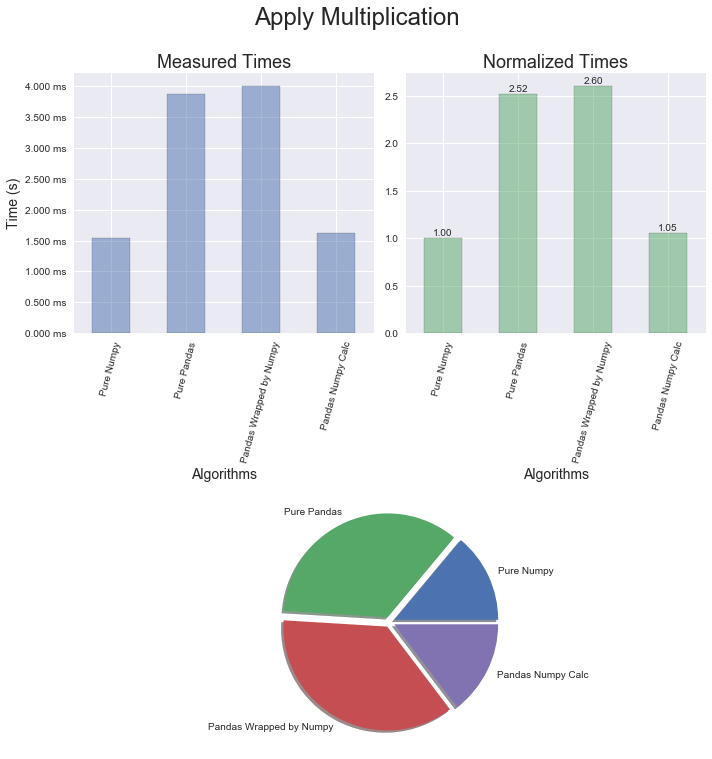

In [22]:
plot_results(apply_across_prod, 'Apply Multiplication')

---
### Apply, Map, Applymap

- These Pandas functions use nested for loop in Python.
- The example problem will be addition again, but forcing Pandas to perform this operation using the agragate functions.

##### Add One to Each Element

In [47]:
setup_numpy = ('import numpy as np;'
               'arr = np.arange(1e6).reshape(1000, 1000);'
               'ones = np.ones((1000, 1000));')
setup_pandas = (setup_numpy
                + ('import pandas as pd;'
                   'df = pd.DataFrame(arr)'))
applymap_labels = labels
applymap_labels.remove('Pandas Wrapped by Numpy')

In [52]:
calls = (
    Call('arr + 1', setup_numpy),
    Call('df.applymap(lambda x: x + 1)', setup_pandas),
    Call('pd.DataFrame(df.values + 1)', setup_pandas),
)
algorithms = OrderedDict(
    {x: time_algorithm(y.cmds, y.setup)
     for x, y in zip(applymap_labels, calls)}
)
applymap_addition = format_times(algorithms)

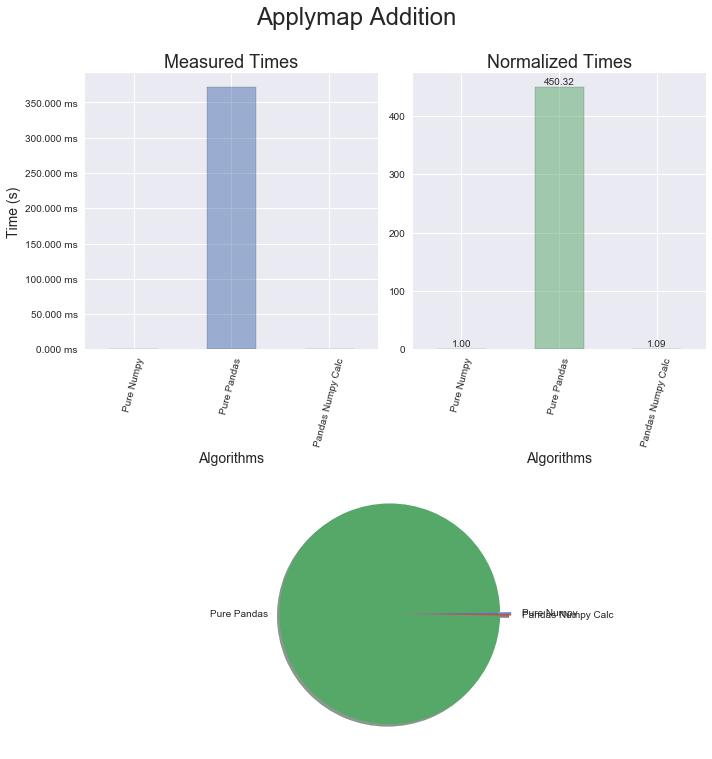

In [53]:
plot_results(applymap_addition, 'Applymap Addition')

---
### Dates

- Pandas is optimized to read ISO 8601 date formats.
    - YYYY-MM-DD HH:MM:SS

In [28]:
setup_pandas = 'import pandas as pd;'

In [23]:
calls = (
    Call('pd.to_datetime("2017-05-28");',
         setup_pandas),
    Call('pd.to_datetime("5/28/2017");',
         setup_pandas),
)
algorithms = OrderedDict(
    {x: time_algorithm(y.cmds, y.setup)
     for x, y in zip(('YYYY-MM-DD', 'month / day / year'), calls)}
)
date_formats = format_times(algorithms)

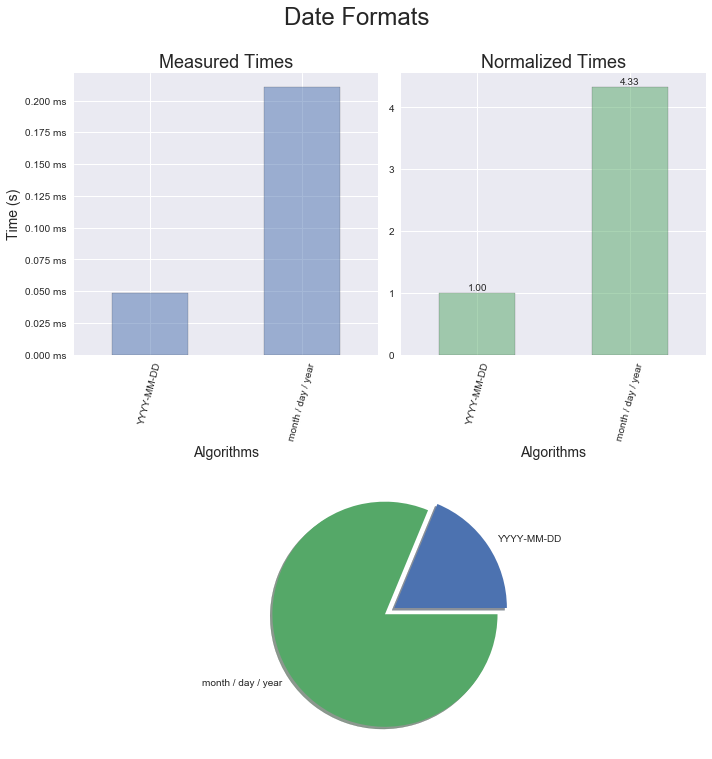

In [24]:
plot_results(date_formats, 'Date Formats')